### Import useful packages

In [86]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

#import plotly_express as px #plotly_express = "0.4.0"
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

import skorch
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV


### Define dataset from MNIST

In [87]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

In [88]:
batch_size = 256
num_epochs = 10
lr = 5e-4 

### Define data transform to tensors and define dataloaders

In [89]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset.transform = transform
test_dataset.transform = transform

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")# 256 batch size 1  28*28 size of pics
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(type(batch_data))
print(type(batch_labels))
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
<class 'torch.Tensor'>
<class 'torch.Tensor'>
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


### Define encoder and decoder

In [90]:
###encoder
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1), 
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(in_features=3*3*32, out_features=64),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x



In [91]:
###decoder
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):

        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(in_features = encoded_space_dim, out_features=64),
            nn.ReLU(True),
            nn.Linear(in_features=64,out_features=3*3*32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
            
                            
        )
    def forward(self,x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x 

### Define autoencoder

In [92]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = Encoder(encoded_space_dim)
        # Decoder
        self.decoder = Decoder(encoded_space_dim)
        
    def forward(self, inputs):
        codes = self.encoder(inputs)
        decoded = self.decoder(codes)
        return codes, decoded

### Make preparation for training

In [93]:
### initialize the two networks

# Set the random seed for reproducible results
torch.manual_seed(2041389)

# Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)
model_AE = AutoEncoder()

In [94]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [95]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

### Define Training function and testing function

In [96]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):

    encoder.train()
    decoder.train()
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('\t partial train loss (single batch): %f' % (loss.data)
)

In [97]:
### Testing function
def test_epoch(encoder,decoder,dataloader,loss_fn,device):
    encoder.eval()
    decoder.eval()
    conc_out = []
    conc_label = []
    for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
    # Create a single tensor with all the values in the lists
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label) 
    # Evaluate global loss
    val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

### Start training

In [98]:
### Training cycle


for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))

    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)


    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))

EPOCH 1/10
	 partial train loss (single batch): 0.148648
	 partial train loss (single batch): 0.144547
	 partial train loss (single batch): 0.149319
	 partial train loss (single batch): 0.146885
	 partial train loss (single batch): 0.146311
	 partial train loss (single batch): 0.145706
	 partial train loss (single batch): 0.149413
	 partial train loss (single batch): 0.149691
	 partial train loss (single batch): 0.150210
	 partial train loss (single batch): 0.150495
	 partial train loss (single batch): 0.147734
	 partial train loss (single batch): 0.147185
	 partial train loss (single batch): 0.147033
	 partial train loss (single batch): 0.146800
	 partial train loss (single batch): 0.143766
	 partial train loss (single batch): 0.146604
	 partial train loss (single batch): 0.148034
	 partial train loss (single batch): 0.147854
	 partial train loss (single batch): 0.149754
	 partial train loss (single batch): 0.146046
	 partial train loss (single batch): 0.142227
	 partial train loss (s

### Plot reconstructed image

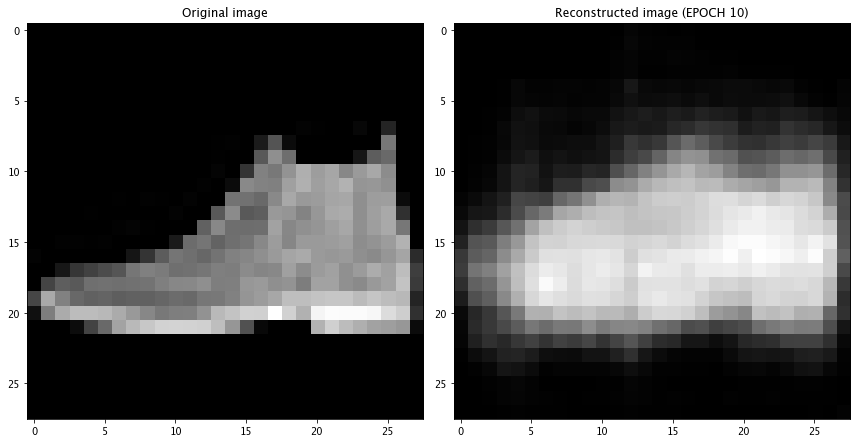

In [99]:
 # Plot the reconstructed image
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0].set_title('Original image')
axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))

plt.tight_layout()
plt.pause(0.1)

### Using grid search to optimize hypermeters

In [100]:
'''
net = NeuralNetClassifier(
    AutoEncoder,    
    max_epochs=50,
    lr=0.1,
    criterion = torch.nn.CrossEntropyLoss(),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    verbose=False,
)
net.fit(batch_data, batch_labels)


#https://nbviewer.org/github/skorch-dev/skorch/blob/master/notebooks/Basic_Usage.ipynb#Usage-with-sklearn-GridSearchCV
#官网示范的栗子
net.set_params(train_split=False, verbose=0)
params = {
    'lr': [5e-4, 5e-3],
    'encoded_space_dim' : [2,10]
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)
gs.fit(batch_data, batch_labels)
print(gs.best_score_, gs.best_params_)

'''

"\nnet = NeuralNetClassifier(\n    AutoEncoder,    \n    max_epochs=50,\n    lr=0.1,\n    criterion = torch.nn.CrossEntropyLoss(),\n    # Shuffle training data on each epoch\n    iterator_train__shuffle=True,\n    verbose=False,\n)\nnet.fit(batch_data, batch_labels)\n\n\n#https://nbviewer.org/github/skorch-dev/skorch/blob/master/notebooks/Basic_Usage.ipynb#Usage-with-sklearn-GridSearchCV\n#官网示范的栗子\nnet.set_params(train_split=False, verbose=0)\nparams = {\n    'lr': [5e-4, 5e-3],\n    'encoded_space_dim' : [2,10]\n}\ngs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)\ngs.fit(batch_data, batch_labels)\nprint(gs.best_score_, gs.best_params_)\n\n"

### Save figures and network parameters

In [101]:
# Save figures
os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
plt.show()
plt.close()

# Save network parameters
torch.save(encoder.state_dict(), 'encoder_params.pth')
torch.save(decoder.state_dict(), 'decoder_params.pth')

In [102]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))


### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)

    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:04<00:00, 2470.45it/s]


,Enc. Variable 0,Enc. Variable 1,label
0,-4.217023,15.852659,9
1,5.767122,-11.892781,2
2,36.816082,13.898494,1
3,33.385921,18.012415,1
4,2.200367,1.760135,6
...,...,...,...
9995,-34.499191,7.485009,9
9996,21.634312,17.180569,1
9997,5.927335,7.073632,8
9998,45.668102,24.377134,1


### Show latent space structure

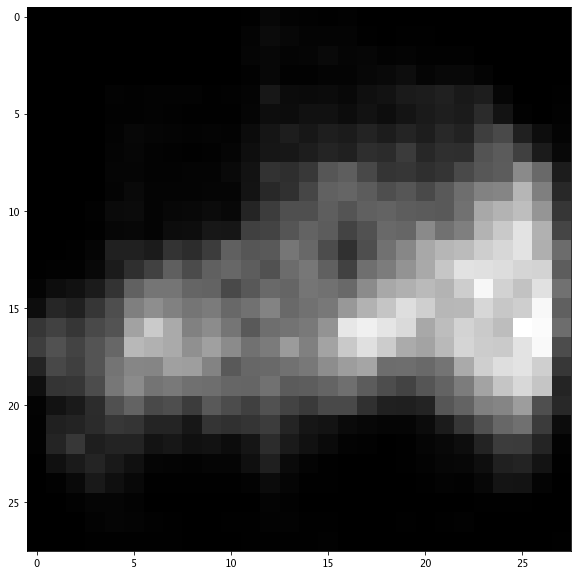

In [103]:
if encoded_space_dim == 2:
    # Generate a new sample
    custom_encoded_sample = [-2, 22.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

### Using PCA 

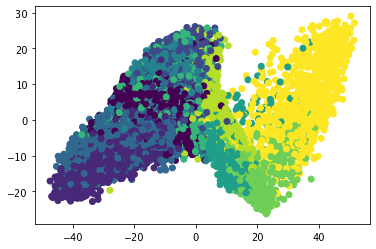

In [104]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA
plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())

### Implement variational autoencoder

#### define VAE model

In [118]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [119]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [120]:
optimizer = torch.optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
#loss_fn = torch.nn.MSELoss()
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [126]:
def train(epoch,dataloader):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.cpu()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))

In [127]:
def test(dataloader):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.cpu()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(dataloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

### Test variational autoencoder

In [128]:
for epoch in range(1, 51):
    train(epoch,train_dataloader)
    test(test_dataloader)

/Users/taomenglu/.local/share/virtualenvs/DeepLearningClassHW-5_10-iC_/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 545.323364
Train Epoch: 1 [25600/60000 (43%)]	Loss: 282.815918
Train Epoch: 1 [51200/60000 (85%)]	Loss: 276.359772
====> Epoch: 1 Average loss: 303.9762
====> Test set loss: 277.2506
Train Epoch: 2 [0/60000 (0%)]	Loss: 284.089325
Train Epoch: 2 [25600/60000 (43%)]	Loss: 269.712708
Train Epoch: 2 [51200/60000 (85%)]	Loss: 273.045105
====> Epoch: 2 Average loss: 271.0017
====> Test set loss: 269.4538
Train Epoch: 3 [0/60000 (0%)]	Loss: 265.204010
Train Epoch: 3 [25600/60000 (43%)]	Loss: 278.186218
Train Epoch: 3 [51200/60000 (85%)]	Loss: 261.157837
====> Epoch: 3 Average loss: 266.5206
====> Test set loss: 267.2958
Train Epoch: 4 [0/60000 (0%)]	Loss: 264.697968
Train Epoch: 4 [25600/60000 (43%)]	Loss: 269.951141
Train Epoch: 4 [51200/60000 (85%)]	Loss: 270.793640
====> Epoch: 4 Average loss: 264.3965
====> Test set loss: 265.2496
Train Epoch: 5 [0/60000 (0%)]	Loss: 265.421112
Train Epoch: 5 [25600/60000 (43%)]	Loss: 262.483490
Train Epoch: 5 [51200/600